In [16]:
# 파이토치 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


# 데이터셋 불러오기
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10, STL10

# 데이터 로더
from torch.utils.data.dataloader import DataLoader, Dataset

# 최적화 알고리즘
from torch.optim import optimizer
from torch.autograd import Variable

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import skimage

import random

import pandas as pd
import sklearn

In [44]:
# 시드 고정
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    return f'현재 사용중인 seed는 [{torch.initial_seed()}]'

fix_seed(1)

'현재 사용중인 seed는 [1]'

# 데이터 불러오기


In [45]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [46]:
deer_path = '/data/gongmo/team4/chan/Test_Image/deer.jpg'
elephant_path = '/data/gongmo/team4/chan/Test_Image/elephant.jpg'
shark1_path = '/data/gongmo/team4/chan/Test_Image/shark1.jpg'
shark2_path = '/data/gongmo/team4/chan/Test_Image/shark2.jpg'

In [47]:
# 이미지 별도로 저장해놓기
deer_img  = plt.imread(deer_path)
elephant_img = plt.imread(elephant_path)
shark1_img = plt.imread(shark1_path)
shark2_img = plt.imread(shark2_path)

In [48]:
# test 이미지 적용
deer = transform(Image.open(deer_path))
elephant = transform(Image.open(elephant_path))
shark1 = transform(Image.open(shark1_path))
shark2 = transform(Image.open(shark2_path))

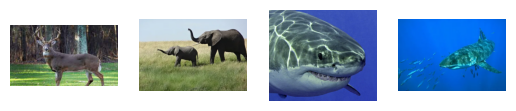

In [49]:
# 원본 이미지 확인
plt.subplot(1,4,1)
plt.imshow(deer_img)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(elephant_img)
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(shark1_img)
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(shark2_img)
plt.axis('off')

plt.show()

# 모델 불러오기 및 CAM 학습용으로 pretrained 모델 재정의


In [50]:
import copy
VGG19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        # 기존 모델 호출
        self.model = copy.deepcopy(VGG19)

        # gradient 추출을 위해 마지막 convolution layer 추출
        self.conv = self.model.features[:-1]

        # convolution 이후 수행되던 max pool 다시 삽입
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # convolution 이후 수행되던 avgpool 다시 삽입
        self.avgpool = self.model.avgpool 

        # 기존 모델에서 사용되던 classifier 삽입
        self.classifier = self.model.classifier

        # 낚아챈 gradient 를 저장하기 위해 변수 선언
        # 최초에는 None, forward 과정에서 hooking 됨
        self.gradient = None

    # activation map의 gradient를 hooking
    def  activations_hook(self, grad):
        self.gradient = grad
        
    def forward(self,x):
        x = self.conv(x)

        # gradient 저장
        # register the hook
        # https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html
        # Tensor.register_hook(hook) -> Tensor or None
        h = x.register_hook(self.activations_hook)

        # max pool 적용
        x = self.max_pool(x)
        
        # avgpool 적용
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [51]:
print(f"pretrained model의 class 개수 : {len(models.VGG19_Weights.DEFAULT.meta['categories'])}")
label = models.VGG19_Weights.DEFAULT.meta['categories']
print(label[:5] + ['...'])

pretrained model의 class 개수 : 1000
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', '...']


In [52]:
model = VGG()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} for running model')
model.to(device)
model.eval() # eval 설정


# 예측 실행
print('********** 예측 실행 **********')
# model이 받는 (batch, channel, width, height) 형태로 만들기 위해 unsqueeze로 차원 추가(3차원 -> 4차원)
# model 결과 중 가장 높은 확률의 index를 출력
# 이후 label과 해당 인덱스를 매칭시켜 결과 출력
print(label[model(deer.to(device).unsqueeze(0)).argmax()])
print(label[model(elephant.to(device).unsqueeze(0)).argmax()])
print(label[model(shark1.to(device).unsqueeze(0)).argmax()])
print(label[model(shark2.to(device).unsqueeze(0)).argmax()])

using cuda for running model
********** 예측 실행 **********
gazelle
African elephant
great white shark
great white shark


In [53]:
# gradient 획득을 위한 예측 실행

# get the gradients of the output with respect to the parameters of the model
pred_deer = model(deer.to(device).unsqueeze(0))
pred_elephant = model(elephant.to(device).unsqueeze(0))
pred_shark1 = model(shark1.to(device).unsqueeze(0))
pred_shark2 = model(shark2.to(device).unsqueeze(0))

In [54]:
print(pred_deer.shape)
print(pred_elephant.shape)
print(pred_shark1.shape)
print(pred_shark2.shape)

torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])


In [55]:
# 예측에 가장 큰 영향을 미친 gradient를 찾고, 미분 실행
print(f'index : {pred_deer.argmax()}')
print(f'last gradient : {pred_deer[:][0][pred_deer.argmax()]}' )

# 비어있는 gradient 확인(최초 None으로 정의됨)
print(f'before get gradient : {model.gradient}')

# gradient 얻기
print(f'******** [ get gradient... ] ********')
pred_deer[:][0][pred_deer.argmax()].backward()
print(f'after backward : {model.gradient.shape}') # gradient 저장됨 확인

index : 353
last gradient : 17.610944747924805
before get gradient : None
******** [ get gradient... ] ********
after backward : torch.Size([1, 512, 14, 14])


In [56]:
# feature map 차원과 일치되게끔 gradient pooling 
pooled_gradient = torch.mean(model.gradient, dim=[0, 2, 3]) # torch.Size([1, 512, 14, 14])
print(pooled_gradient.shape) # torch.Size([512])

torch.Size([512])


In [57]:
# feature map 획득
feature_map =  model.conv(deer.to(device).unsqueeze(0))
print(f'feature map의 shape : {feature_map.shape}')

feature map의 shape : torch.Size([1, 512, 14, 14])


In [58]:
# pooled_gradient * feature map
for i in range(len(pooled_gradient)):
    feature_map[:,i,:,:] *= pooled_gradient[i]

In [59]:
# 전체 차원 평균 해주기
mean_feature_map = torch.mean(feature_map, dim=1)

In [60]:
# relu를 적용하여 heatmap 획득
heatmap = np.maximum(mean_feature_map.detach().cpu(), 0) # shape : (1, 14, 14)
heatmap /= torch.max(heatmap) # 최대값으로 나누어 정규화
heatmap = heatmap.squeeze() # 차원 줄이기, shape (14, 14)

(-0.5, 13.5, 13.5, -0.5)

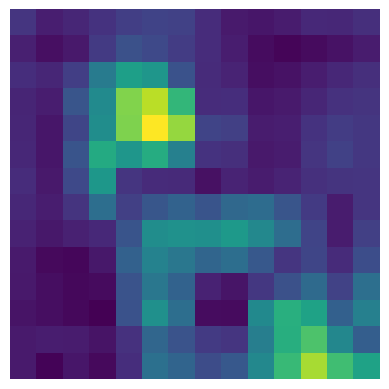

In [61]:
# 이미지 확인
plt.imshow(heatmap)
plt.axis('off') 

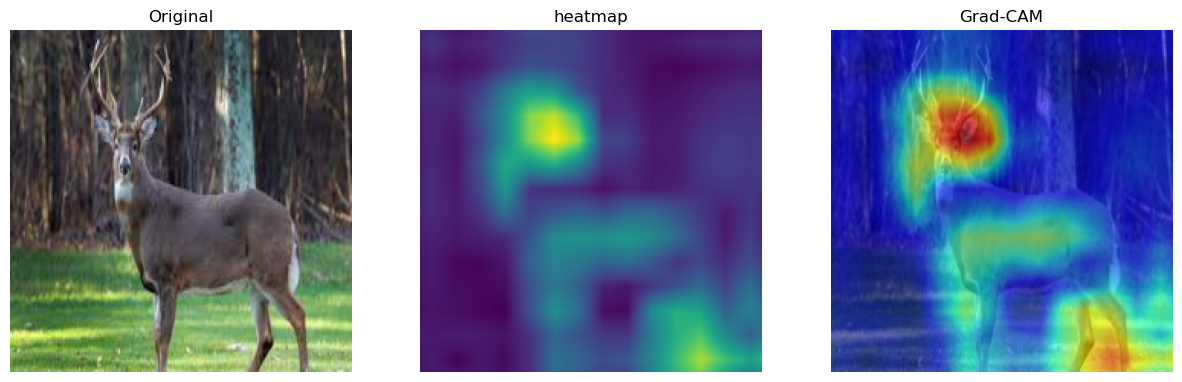

In [62]:
# 최종 출력시킬 이미지 해상도 설정(가로, 세로)
size = 224

# 동일 size로 맞춰주기
mask = skimage.transform.resize(heatmap, (size,size))
image = skimage.transform.resize(deer_img, (size,size))

plt.figure(figsize=(15,5))

# 원본 이미지 출력
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Original')

# heatmap 출력
plt.subplot(1,3,2)
plt.imshow(mask)
plt.axis('off')
plt.title('heatmap')


plt.subplot(1,3,3)
# CAM 결과와 함께 출력
plt.imshow(mask, cmap='jet')
plt.imshow(image, alpha=0.4)
plt.axis('off')
plt.title('Grad-CAM')
plt.show()